# Лабораторная работа: Кодирование информации и шифрование с использованием хаотических систем  
 


## Информация  
---
> **Группа:** *[21.2] Дифференциальные уравнения*
> 1. ФИО, ИСУ:  Усюкин Герман Юрьевич 409739
---


Исследовать применение хаотических систем (аттрактор Лоренца и уравнений в частных производных) для **генерации криптографических ключей** и **шифрования информации**, а также проанализировать устойчивость этих систем через **функцию Ляпунова** и **вероятностные методы**.  


В этой работе вы будете использовать следующие библиотеки Python:

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import hashlib
import random

# Первая часть

## Введение в аттракторы

>**Определение аттрактора**: 
>
>Аттрактор — это множество в фазовом пространстве системы дифференциальных уравнений, к которому сходятся траектории системы при $ t \to \infty $, независимо от начальных условий. Например, для системы с устойчивым равновесием, аттрактором будет сама точка равновесия.  

**Аттрактор Лоренца** — это трехмерное **хаотический** притягивающее множество, образующийся в системе:  
$$  
\begin{cases}  
\dot{x} = \sigma(y - x), \\  
\dot{y} = x(\rho - z) - y, \\  
\dot{z} = xy - \beta z,  
\end{cases}  
$$  
где:  
- $ \sigma $ (коэффициент Прандтля) управляет скоростью сближения траекторий по оси $ x $.  
- $ \rho $ (число Рейнольдса) определяет, возникает ли хаос: при $ \rho = 28 $ система демонстрирует хаос.  
- $ \beta $ (отношение размеров) задает геометрию аттрактора (например, $ \beta = \frac{8}{3} $).  

**Хаотический аттрактор Лоренца** имеет форму двух "крыльев", и его траектории чувствительны к начальным условиям — ключевое свойство для криптографии. Это означает, что даже малые изменения $ x(0), y(0), z(0) $ приводят к радикально разным траекториям, что делает его идеальным для генерации **непредсказуемых ключей**.  

## Что нужно сделать  

1. **Выбор параметров**:  
   Используйте классические значения для хаоса:  
   $$  
   \sigma = 10.0, \quad \rho = 28.0, \quad \beta = \frac{8}{3}.  
   $$  

2. **Решение системы**:   
   - Начальные условия $ (x_0, y_0, z_0) $ могут быть произвольными.  
   - Временной интервал $ t $ и достаточно плотная сетка $ t $ для детализации траектории.  

3. **Анализ координаты $ x(t) $**:  
   Используйте координату $ x(t) $ для генерации ключа, так как она демонстрирует хаотическое поведение, чувствительное к начальным условиям.  



---
> ***Вопрос***
>
> Как чувствительность к начальным условиям проявляется на графике? 
>
> ***Ответ:***
1) Чем больше $\sigma$, тем быстрее мы сближаемся к точке устойчивости
2) При $\rho$ близким к 28 система ведет себя максимально хаотично, если же мы уходим в ноль или наоборот ставим слишком большое значение система становится "сдержаннее" что ли
3) Поигравшись с $\beta$ можно заметить изменения форм, но ничего интереснее, чем при значении 8/3 я не нашел
---



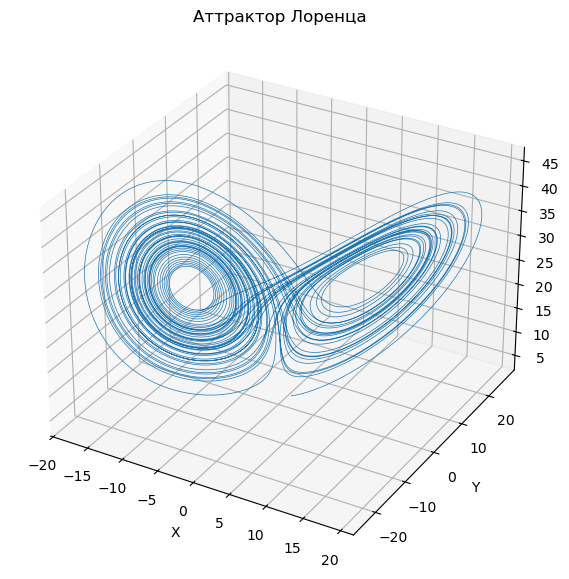

In [22]:
# начальные условия
sigma = 10
rho = 28
beta = 8/3

def lorenz(t, state):
    x, y, z = state
    dxdt = sigma*(y - x)
    dydt = x*(rho - z) - y
    dzdt = x*y - beta*z
    return [dxdt, dydt, dzdt]

# инициализация
initial_state = [1, 2, 3]
t_span = (0, 50)
t_eval = np.linspace(0, 50, 10000)
# аналитическое решение
sol = solve_ivp(lorenz, t_span, initial_state, t_eval=t_eval)
x = sol.y[0]
y = sol.y[1]
z = sol.y[2]

# Построение графика
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, lw=0.5)
ax.set_title("Аттрактор Лоренца")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

## Хэширование 

**Хэширование для усиления безопасности**:  
Для преобразования вещественного значения $x(t)$ в целочисленный ключ используется хэш-функция SHA-256:  
$$  
H(x(t)) = \text{SHA-256}(\text{str}(x(t))).  
$$  
Хэш $H(x(t))$ — это строка из 64 шестнадцатеричных символов (256 бит). Мы извлекаем первые 8 байт (64 бита) и преобразуем их в целое число:  
$$  
\text{key\_part} = \left( \text{int}(H(x(t))[:8], 16) \right) \mod 256.  
$$  
Операция $\mod 256$ гарантирует, что $\text{key\_part} \in [0, 255]$, совместимый с **ASCII-кодировкой**.  

**Почему сообщение должно быть на латинице?**  
Символы латинского алфавита в ASCII кодируются **7 битами**, но для удобства используются 8 бит (диапазон [0, 255]). Это обеспечивает синхронизацию ключа и текста при шифровании:  
$$  
\forall i \in [1, \text{key\_length}], \quad \text{plaintext}[i] \in \{0, 1\}^8, \quad \text{key}[i] \in [0, 255].  
$$  


## Что нужно сделать  

Для каждого значения $x(t)$:  
- Примените хэш-функцию SHA-256.
- Извлеките первые 8 байт хэша (64 шестнадцатеричных символа).
- Преобразуйте $\text{hash\_slice}$ в целое число по основанию 16:  
        $$  
        \text{key\_part} = \text{int}(\text{hash\_slice}, 16).  
        $$  
- Примените модуль 256, чтобы получить 8-битный байт:  
        $$  
        \text{key\_part} = \text{key\_part} \mod 256.  
        $$  


---
> ***Вопрос***
>
> 1. Почему модулярное сложение лучше простого сложения без модуля? 
> 2. Как хаотический ключ повышает безопасность по сравнению с случайным ключом? 
> 3. Что произойдет, если ключ короче текста? 
>
> ***Ответ:***
1) Потому что мы заинтересованы в получении значений в интервале 256, что эквивалентно 8 битам, а также по тому, что деление по модулю убирает информацию об изначальном значении
2) Хаотический ключ более чувствителен к начальным условие, то есть даже при малейшем изменении их, он может выдавать кардинально противоположные значения, случайные ключи более просто, потому что они алгоритмические и в них легче найти закономерность
3) Придется придумывать какое нибудь решение, например зациклить ключи
---
     

In [23]:
# генерация ключа
def generate_key(x_values, key_length):
    key = []
    for i in range(key_length):
        x = x_values[i % len(x_values)]  # зацикливаем, если key_length > len(x_values)
        x_str = str(x).encode('utf-8')
        hash_hex = hashlib.sha256(x_str).hexdigest()
        hash_slice = hash_hex[:16]
        key_part = int(hash_slice, 16) % 256
        key.append(key_part)

    return key
# проверка на корректность ключа (визуальная)
plaintext = "YOUR_MESSAGE"
key_length = len(plaintext)
key = generate_key(x, key_length)
print(f'Key: {key}')

Key: [207, 106, 148, 7, 206, 76, 40, 228, 250, 171, 115, 139]


## Шифрование

**Шифрование**:  
Для каждого байта текста $ P_i $ и ключа $ K_i $:  
$$  
C_i = (P_i + K_i) \mod 256,  
$$  
где $ C_i $ — зашифрованный байт.  

**Расшифровка**:  
$$  
P_i = (C_i - K_i) \mod 256.  
$$  

### Что нужно сделать?

1. **Функция `encrypt`**:  
   - **Входные данные**:  
     - `plaintext` — строка секретного сообщения.  
     - `key` — список целых чисел (0–255), длиной, равной длине текста.  

2. **Функция `decrypt`**:  
   - **Входные данные**:  
     - `ciphertext_hex` — шестнадцатеричная строка, полученная из `encrypt`.  
     - `key` — тот же ключ, что и при шифровании.  


In [24]:
# функция энкодера
def encrypt_lorentz(plaintext: str, key: list) -> str:
    encoded_message = ''
    for i in range(len(plaintext)):
        encoded_message += chr((ord(plaintext[i]) + key[i]) % 256)
    return encoded_message

In [25]:
# функция декодера
def decrypt_lorentz(ciphertext_hex: str, key: list) -> str:
    decoded_message = ''
    for i in range(len(ciphertext_hex)):
        decoded_message += chr((ord(ciphertext_hex[i]) - key[i]) % 256)
    return decoded_message



In [26]:
ciphertext = encrypt_lorentz(plaintext, key)
decrypted_text = decrypt_lorentz(ciphertext, key)
# Проверка
print("Исходный текст:", plaintext)
print("Расшифрованный текст:", decrypted_text)

Исходный текст: YOUR_MESSAGE
Расшифрованный текст: YOUR_MESSAGE


## Белый шум
> **Белый шум** — это случайный сигнал, где каждое значение независимо и одинаково распределено. В данном случае, при добавлении шума в шифротекст, мы используем **равномерное распределение** $ U \sim \mathcal{U}(0, 255) $

Это распределение моделирует **равномерные случайные искажения**, которые могут возникать в реальных каналах передачи данных (например, помехи в радиосигналах или ошибки при хранении).  


### Что делать?
- Функция добавления белого шума:
Реализуйте функцию `add_noise`, которая:  
   - С вероятностью $ p $ заменяет байт на случайное значение $ \mathcal{U}(0, 255) $.  
   -  Возвращает искаженные данные.  
- Функция оценки ошибок:
Используйте функцию `error_rate`, которая:  
  - Сравнивает исходный текст и расшифрованный.  
  - Возвращает процент ошибок.  
- Проведите $ N = 1000 $ экспериментов для фиксированного $ p $.  
  - Вычислите:  
      - $ \mathbb{E}[E]$,  
      - $ \mathbb{Var}(E)$.  

- Оцените результат.  




In [27]:
# еее белый шум
def add_noise(data, p: float):
    for i in range(len(data)):
        if random.random() < p:
            data[i] = random.randint(1, 255)
    return data

ciphertext_bytes = [ord(word) for word in ciphertext]
noisy_ciphertext_bytes = add_noise(ciphertext_bytes, 0.5)
noisy_ciphertext_hex = ''.join(chr(noisy_ciphertext_byte) for noisy_ciphertext_byte in noisy_ciphertext_bytes)
decrypted_with_ciphertext_noise = decrypt_lorentz(noisy_ciphertext_hex, key)

print(f"Расшифрованный с шумным шифротекстом: {decrypted_with_ciphertext_noise}")

Расшифрованный с шумным шифротекстом: OURUMESSAG


In [28]:
# Loss function
def error_rate(original, decrypted):
    count_misses = 0
    for i in range(len(original)):
        if original[i] != decrypted[i]:
            count_misses += 1
    return 100 * count_misses / len(original)

print(f"Ошибка при шумном шифротексте: {error_rate(plaintext, decrypted_with_ciphertext_noise):.3f}%")

Ошибка при шумном шифротексте: 25.000%


In [31]:
# Проверка статистик
N = 1000
p = 0.3
stats = []
for i in range(N):
    ciphertext_bytes = [ord(word) for word in ciphertext]
    noisy_ciphertext_bytes = add_noise(ciphertext_bytes, p)
    noisy_ciphertext_hex = ''.join(chr(noisy_ciphertext_byte) for noisy_ciphertext_byte in noisy_ciphertext_bytes)
    decrypted_with_ciphertext_noise = decrypt_lorentz(noisy_ciphertext_hex, key)
    stats.append(error_rate(plaintext, decrypted_with_ciphertext_noise))

print(f'E = {np.mean(stats):.3f}')
print(f'Var = {np.var(stats, ddof=1):.3f}')

E = 30.192
Var = 176.209


Значение матожидания довльно близко к теоретическому

## Вывод

Что вы узнали, выполняя это задание? Не забудьте подвести итог.

Я узнал как с помощью дифф. уравнений можно шифровать ключи букв, а в частности благодаря Аттрактору Лоренца, также понял что даже при небольшом шуме зашифрованное сообщение бывает тяжело однозначно дешифровать

# Вторая часть

## Уравнение и описание

Представьте, что вы хотите описать распространение сигнала в среде, где одновременно действуют два процесса: **диффузия** и **реакция**. Это описывается **уравнением реакции-диффузии**:  
$$  
u_t = D u_{xx} + f(u),  
$$  
где:  
- $ u(t, x) $ — амплитуда сигнала в точке $ x $ и момент времени $ t $.  
- $ D $ — коэффициент диффузии, определяющий скорость рассеяния сигнала.  
- $ f(u) $ — функция реакции, которая может создавать **стационарные решения** — точки равновесия системы.  

>**Определение стационарного решения**:  
>Это решение $ u(x) $, которое не зависит от времени ($ u_t = 0 $), то есть удовлетворяет уравнению:  
>$$  
>0 = D u_{xx} + f(u).  
>$$  
Независимо от начального условия, система сойдётся к этим решениям через время.  

В криптографии его используют для генерации **непредсказуемых ключей**, основанных на хаотической динамике. Например, если выбрать $ f(u) = u - u^3 $, то стационарные решения $ u = \pm 1 $ становятся аттракторами.*Почему хаос и устойчивость одновременно полезны для шифрования?* Хаос создает непредсказуемые ключи, а устойчивость обеспечивает, что ключ можно восстановить, даже если среда передачи добавляет шум.  

---

## Численное решение: что нужно сделать?  

Ваша задача — реализовать уравнение $ u_t = D u_{xx} + u - u^3 $ с помощью метода **конечных разностей**. Вот как это сделать:  

1. **Дискретизация пространства и времени**:  
   - Разбейте пространство на точки с шагом $ \Delta x $. Например, если длина области $ L = 100 $, а $ \Delta x = 0.5 $, то общее количество точек $ N_x = L/\Delta x = 200 $.  
   - Разбейте время на шаги $ \Delta t $, например, $ \Delta t = 0.01 $.  

2. **Начальное условие**:  
   Задайте начальное состояние $ u(0, x) $, например, прямоугольный импульс в центре:  
   $$  
   u(0, x) = \begin{cases}  
   1, & \text{в центре}, \\  
   0, & \text{вокруг}.  
   \end{cases}  
   $$  
   Это имитирует "сигнал", который будет эволюционировать в аттракторы.  

3. **Итерационный процесс**:  
   В каждом временном шаге обновляйте значения $ u $ с помощью формулы:  
   $$  
   u^{n+1}_i = u^n_i + \Delta t \left( D \frac{u^n_{i+1} - 2u^n_i + u^n_{i-1}}{(\Delta x)^2} + u^n_i - (u^n_i)^3 \right).  
   $$  
   Здесь:  
   - Диффузия $ D u_{xx} $ моделирует рассеяние сигнала.  
   - Реакция $ f(u) = u - u^3 $ "тянет" значения $ u $ к аттракторам $ \pm 1 $.  


In [32]:
# Начальные условия
L = 100
dx = 0.5
T = 15
dt = 0.01
D = 1

# Функция, где реализовано уравнение
def reaction_diffusion(D: float, L: int, T: int, dx: float, dt: float) -> np.array:

    # Дескретизация
    x_space = np.linspace(0, L, int(L/dx))
    t_space = np.linspace(0, T, int(T/dt))

    # Начальное условие
    u = np.zeros((len(t_space), len(x_space)))
    radius = 5
    center = int(L/dx) // 2
    u[0, center - radius : center + radius] = 1.0

    u_new = np.copy(u)

    # Итерационный процесс
    for n in range(len(t_space) - 1):
        for i in range(1, len(x_space) - 1):
            u_xx = (u[n, i + 1] - 2 * u[n, i] + u[n, i - 1]) / dx**2
            reaction = u[n, i] - u[n, i]**3
            u_new[n + 1, i] = u[n, i] + dt * (D * u_xx + reaction)

        # Граничные условия
        u_new[n + 1, 0] = u_new[n + 1, 1]
        u_new[n + 1, -1] = u_new[n + 1, -2]

        u[:] = u_new[:]

    return u

u_signal = reaction_diffusion(D, L, T, dx, dt)

## Теория

Функция Ляпунова записывается как:  
$$  
V(u) = \frac{D}{2} \int (u_x)^2 dx + \frac{1}{4} \int (1 - u^2)^2 dx.  
$$  
Эта функция состоит из двух частей:  
1. **Кинетический член** $ \frac{D}{2} (u_x)^2 $: отражает энергию, связанную с градиентом сигнала (чем резче границы между аттракторами, тем выше энергия).  
2. **Потенциальный член** $ \frac{1}{4} (1 - u^2)^2 $: измеряет отклонение от стационарных решений $ u = \pm 1 $.  

Если $ V(t) $ **монотонно убывает** со временем, система устойчива — решение сходится к аттракторам. Если $ V(t) $ растет или колеблется, система нестабильна, и ключ, сгенерированный из этого решения, может быть нарушен даже при небольших помехах.  

## Что делать?

Ваша задача — реализовать функцию `lyapunov_function`, которая вычисляет $ V(u) $ для каждого временного слоя решения $ u_{signal} $, и построить график $ V(t) $.  

**Подсказка**:  
1. **Вычисление производной**:  
   - Производная $ u_x $ аппроксимируется через разницу между соседними точками:  
     $$  
     u_x \approx \frac{u_{i+1} - u_i}{\Delta x}.  
     $$  

2. **Постройте график** $ V(t) $ и проверьте, что он **монотонно убывает**.  


---
> ***Вопрос***
>
> Что произойдет, если график $ V(t) $ будет расти?
>
> ***Ответ:***
это будет свидетельствовать о том что система переходит в хаотическое состояние, где её поведение будет сильно зависеть от начальных условий. В этом случае сигнал, генерируемый системой, может стать слишком предсказуемым и поэтому легко может быть расшифрован
---

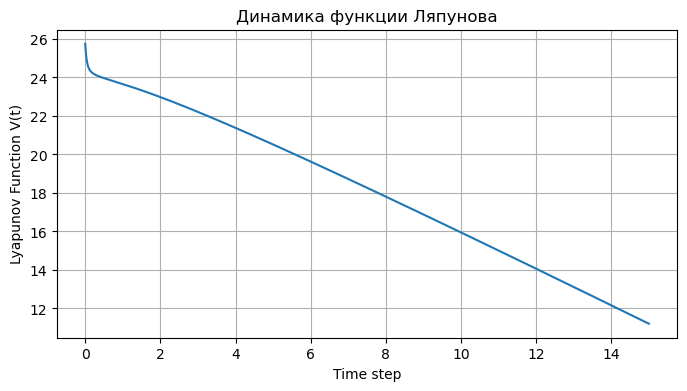

In [33]:
#  Функция Ляпунова
def lyapunov_function(u, D: float, dx: float) -> float:

    u_x = (u[1:] - u[:-1]) / dx
    kinetic = (D / 2) * np.sum(u_x**2) * dx
    potential = (1 / 4) * np.sum((1 - u**2)**2) * dx
    return kinetic + potential

V_values = []

for t in range(u_signal.shape[0]):
    V_values.append(lyapunov_function(u_signal[t], D, dx))

t = np.linspace(0, T, int((T/dt)))
# График функции Ляпунова
plt.figure(figsize=(8, 4))
plt.plot(t,V_values)
plt.xlabel("Time step")
plt.ylabel("Lyapunov Function V(t)")
plt.title("Динамика функции Ляпунова")
plt.grid(True)
plt.show()




## Генерация ключа

Хаотическая динамика системы реакции-диффузии, описанной уравнением:  
$$  
u_t = D u_{xx} + u - u^3,  
$$  
дает **непредсказуемый переходный процесс**, который идеален для генерации ключей. Даже небольшие изменения начальных условий или параметров $ D $ приводят к радикально разным решениям, что делает ключ **уникальным и непредсказуемым**.  

Однако, чтобы использовать сигнал $ u(t,x) $ в криптографии, его нужно привести к **целочисленному формату** (например, байты от 0 до 255).

## Что нужно реализовать?  

Ваша задача — написать функцию `generate_key_from_PDE`, которая:  
1. Берет **сигнал** $ u(t,x) $.  t - подбирается оптимально
2. Нормализует значения из диапазона $ [-1, 1] $ в диапазон **[0, 255]**, чтобы получить 8-битные значения.  

**Нормализация**:  
$$  
K_i = \left( \frac{u(t,x_i) + 1}{2} \right) \cdot 255,
$$  
где:  
- $ K_i $ — значение ключа для байта $ i $.  
- $ u(0,x_i) $ — амплитуда сигнала в момент времени t в точке $ x_i $.


---
> ***Вопрос***
>
> Почему мы используем $ u(t,x) $, а не $ u(T,x) $ (финальное состояние)?
>
> ***Ответ:*** Потому что в начале система более чувствительна к маленьким изменениям, в финальном же состоянии, она почти не меняет своего значения при небольшом изменении
---

In [34]:
# Генератор ключа по заданным условиям
def generate_key_from_PDE(u_signal: np.array, key_length: int, t: int = None) -> int:
    if t is None:
        t_index = u_signal.shape[0] // 2
        u_t = u_signal[t_index]
    else:
        u_t = u_signal[t]

    # Нормализация: [-1, 1] → [0, 255]
    u_norm = ((u_t + 1) / 2) * 255
    u_256 = np.clip(u_norm, 0, 255)
    u_int = u_256.astype(int)
    return u_int[:key_length]

plaintext = "SECRET_MESSAGE"
key_length = len(plaintext)
key = generate_key(u_signal, key_length)
print(f'Key: {key}')

Key: [154, 118, 105, 30, 193, 85, 172, 171, 148, 69, 0, 122, 136, 109]


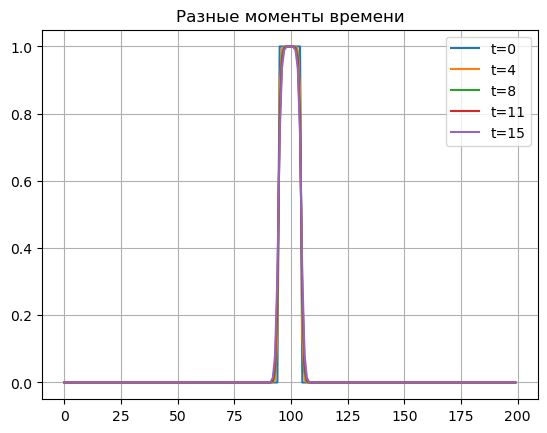

In [35]:
times = np.linspace(0, T, 5).round().astype(int)
for t in times:
    plt.plot(u_signal[t], label=f't={t}')
plt.legend()
plt.title("Разные моменты времени")
plt.grid(True)
plt.show()


## Как работает XOR-шифрование?  

XOR-шифрование — это простой, но эффективный метод симметричного шифрования, где каждый бит текста **XOR-сочетается** с соответствующим битом ключа:  
$$  
C_i = P_i \oplus K_i,  
$$  
где:  
- $ C_i $ — зашифрованный бит.  
- $ P_i $ — бит исходного текста.  
- $ K_i $ — бит ключа.  

**Обратимость**:  
$$  
P_i = C_i \oplus K_i \quad \text{потому что} \quad (P \oplus K) \oplus K = P.  
$$  


## Что делать?  
Ваша задача — реализовать функцию `encrypt`, которая:  
1. Преобразует текст и ключ в **бинарные строки** (последовательности 0 и 1).  
2. Выполняет побитовое XOR между текстом и ключом.  
3. Возвращает зашифрованный текст в виде строки битов.  



---
> ***Вопрос***
>
> Как хаотический ключ повышает безопасность по сравнению с случайным ключом?
>
> ***Ответ:*** Хаотический ключ легче воссодзать зная начальные условия, случайный же ключ можно воссоздать зная seed, но как я понимаю случайность не всегда от него зависит, плюс диффуры сложнее решать, чем закономерности искать)
---


In [36]:
# XOR енкодер
def encrypt(text: str, key: int) -> str:
    encoded_message = ''
    for i in range(len(text)):
        encoded_message += format(ord(text[i]) ^ key[i % len(key)], '08b')
    return encoded_message

## Как работает расшифровка?  

XOR-шифрование обратимо благодаря свойству:  
$$  
C \oplus K = P \quad \text{если} \quad C = P \oplus K.  
$$  
Это означает, что чтобы получить исходный текст, нужно применить XOR к шифротексту и тому же ключу.  

## Что нужно сделать?  

Ваша задача — реализовать функцию `decrypt`, которая:  
1. Преобразует ключ в бинарную строку (как в `encrypt`).  
2. Выполняет XOR между **шифротекстом** и ключом побитно.  
3. Разбивает результат на блоки по 8 бит (один байт), преобразует их в символы ASCII и собирает текст.  


---
> ***Вопрос***
>
> Как устойчивость системы (анализ через функцию Ляпунова) влияет на расшифровку?
>
> ***Ответ:*** Если система неустойчива, то при одних и тех же входных данных могут быть разные ключи, что мешает воспроизводимости
---

In [37]:
# XOR декодер
def decrypt(ciphertext: str, key: int) -> str:
    decoded_message = ''
    bytes = []
    for i in range(0, len(ciphertext), 8):
        byte = ciphertext[i:i+8]
        num = int(byte, 2)
        bytes.append(num)
    for i in range(0, len(bytes)):
        decoded_char = chr(bytes[i] ^ key[i % len(key)])
        decoded_message += decoded_char
    return decoded_message


In [38]:
ciphertext = encrypt(plaintext, key)
decrypted_text = decrypt(ciphertext, key)


# Проверка правильности, тоже визуальная
print("Исходный текст:", plaintext)
print("Расшифрованный текст:", decrypted_text)

Исходный текст: SECRET_MESSAGE
Расшифрованный текст: SECRET_MESSAGE


## Что делает этот код?  

Этот блок строит два графика:  
1. **Функция Ляпунова $ V(t) $**: Показывает, как энергия системы изменяется со временем.  
2. **Стационарное решение $ u(T,x) $**: Отображает конечное состояние системы после сходимости к аттракторам.  

---
> ***Вопрос***
>
> 1. Что произойдет с графиком $ V(t) $, если начальное условие сильно отличается от аттракторов?
> 2. Почему стационарное решение имеет значения $ \pm 1 $?
> 3. Как форма графика $ u(T,x) $ влияет на выбор параметра $ D $?
>
> ***Ответ:*** 1)Если начальное условие сильно отличается от аттракторов, график $ V(t) $ будет колебаться и показывать высокую энергию в переходный период, прежде чем система стабилизируется на одном из аттракторов.
>
> 2) Стационарное решение имеет значения $ \pm 1 $, потому что для функции реакции $ f(u) = u - u^3 $, стационарные точки (где $ u_t = 0 $) находятся при $ u = \pm 1 $, когда производная функции равна нулю.

3)Форма графика $ u(T,x) $ влияет на выбор параметра $ D $, так как $ D $ определяет скорость диффузии. Большие значения $ D $ приводят к более быстрым изменениям в пространстве, влияя на форму профиля $ u(T,x) $, а малые $ D $ замедляют распространение сигнала.


---


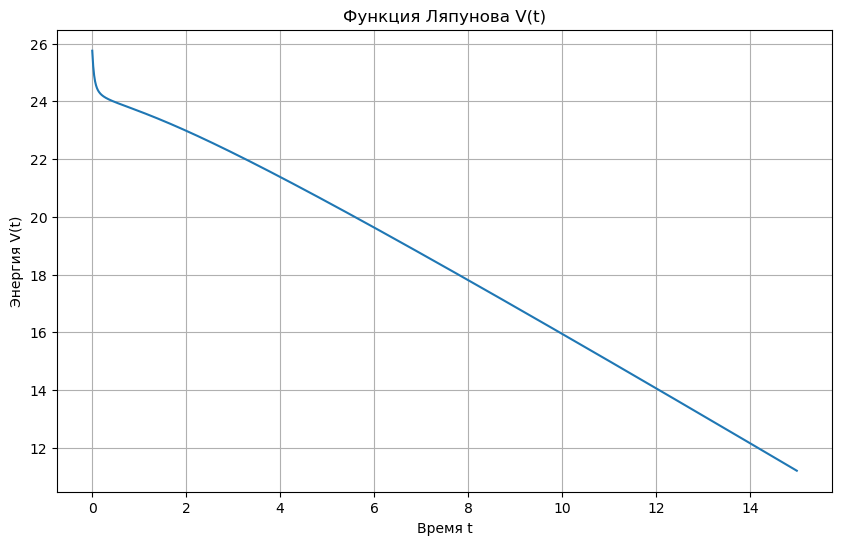

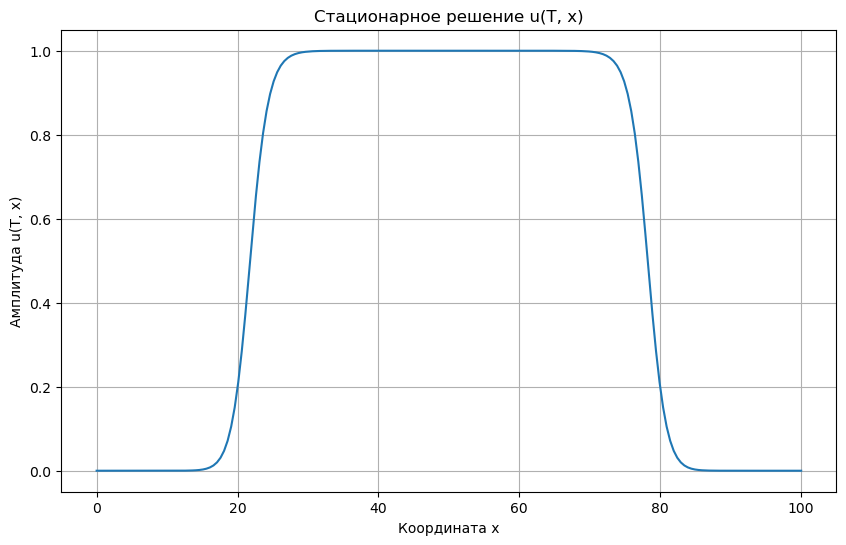

In [39]:
# График функции Ляпунова V(t)
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, T, int(T/dt)), V_values)
plt.title("Функция Ляпунова V(t)")
plt.xlabel("Время t")
plt.ylabel("Энергия V(t)")
plt.grid(True)

# График стационарного решения u(T, x)
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0 ,L, int(L/dx)), u_signal[-1])  # Последний временной слой
plt.title("Стационарное решение u(T, x)")
plt.xlabel("Координата x")
plt.ylabel("Амплитуда u(T, x)")
plt.grid(True)

plt.show()

## Вывод

Что вы узнали, выполняя это задание? Не забудьте подвести итог.

В ходе выполнения задания я исследовал динамику системы реакции-диффузии и изучил, как диффуры могут быть использованы для генерации непредсказуемых ключей для криптографических целей. Также рассмотрел важность стабилизации системы в аттракторах и влияние параметра диффузии на форму и скорость изменения сигнала


Вот бы ML, а не эта криптография